In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from glob import glob

In [3]:
RGB_acq_list= glob("/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq*/")
RGB_acq_list.sort(key=lambda x: int(x.split("/")[-2].split("_")[0].split("q")[-1]))
RGB_acq_list

['/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq1_9600_0_1/',
 '/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq2_9600_0_1.5/',
 '/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq3_9600_0_2/',
 '/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq4_9600_1_1/',
 '/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq5_9600_1_1.5/',
 '/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq6_9600_1_2/',
 '/Users/vsahu/Downloads/DATA/machine_studies/PLI10/studies290524/light_source_preset/cpl-cpl/ccw/acA5472-17uc/RGB8/Off/acq7_9600_2_1/',
 '/Users/vsahu/Downloads/DATA/machine

In [4]:
def filter_acq_list(acq_list, mode = None, value = None):

    '''
    This function filters the acquisition list based on the mode and their respective values provided.
    Modes: 
        - gain       : input type float
        - exposure   : input type int
        - gamma      : input type float
        - gain_gamma : input type tuple (float, float)

    Parameters:
        acq_list : list of acquisitions
        mode     : mode of filtering
        value    : value of the mode

    Returns:
        acq_list_filtered : filtered list of acquisitions
    '''
    acq_list_filtered = []
    if mode == "gain":
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[2]) == value:
                acq_list_filtered.append(acq)
    elif mode == "exposure":
        for acq in acq_list:
            if int(acq.split("/")[-2].split("_")[1]) == value:
                acq_list_filtered.append(acq)

    elif mode == "gamma":
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[3]) == value:
                acq_list_filtered.append(acq)
    
    elif mode == "gain_gamma":
        
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[2]) == value[0] and float(acq.split("/")[-2].split("_")[3]) == value[1]:
                acq_list_filtered.append(acq)
    elif mode == None and value == None:
        acq_list_filtered = acq_list

    return acq_list_filtered

def extract_RGB(image):
    
    ''' 
    This function extracts the red, green and blue channels of the input image.

    Parameters:
        image : input image

    Returns:
        red   : red channel of the image
        green : green channel of the image
        blue  : blue channel of the image
    '''

    red = image[:, :, 0]
    green = image[:, :, 1]
    blue = image[:, :, 2]

    return red, green, blue

def cal_mean_intensity(acq_list,mode="gain", value=0, ext="png"):

    '''
    This function calculates the mean intensity of the acquisitions in the acquisition list.

    Parameters:
        acq_list : list of acquisitions
        mode     : mode of filtering
        value    : value of the mode

    Returns:
        mean_intensities : list of mean intensities of the acquisitions
    '''
    
    acq_list_filtered = filter_acq_list(acq_list,mode, value)
    
    mean_intensities = []
    for acq in acq_list_filtered:
        img_list = glob(acq + "/*.png")
        mean_intensity = []
        for ind in range(len(img_list)):
            img = io.imread(f"{acq}/{ind}.png")
            G_channel= img.mean()
            mean_intensity.append(G_channel)
        label = acq.split("/")[-2].split("_")[0]
        mean_intensities.append((mean_intensity, label))

    return mean_intensities
def get_acq_info(label,acq_list):
    '''
    This function extracts the acquisition information from the acquisition list.
    
    Parameters:
        label    : label of the acquisition
        acq_list : list of acquisitions
        
    Returns:
        acq_name : name of the acquisition
        exposure : exposure of the acquisition
        gain     : gain of the acquisition
        gamma    : gamma of the acquisition
    '''

    acq = [acq for acq in acq_list if label in acq][0]
    acq_name = acq.split("/")[-2]
    exposure = int(acq_name.split("_")[1])
    gain = float(acq_name.split("_")[2])
    gamma = float(acq_name.split("_")[3])


    return acq_name, exposure, gain, gamma

def inv_gamma(x,gamma):
    # print(x)
    temp=np.zeros(len(x))
    for i in range(len(x)):
        # print(x[i], 255 * (x[i]/255)**(1/gamma))
        temp[i] =255 * (x[i]/255)**(1/gamma)
    return temp

def cal_mean_intensity_by_channels(acq_list, mode="gain", value=0, ext="png"):

    '''
    This function calculates the mean intensity of the acquisitions in the acquisition list by channels.

    Parameters:
        acq_list : list of acquisitions
        mode     : mode of filtering
        value    : value of the mode

    Returns:
        mean_intensities_R : list of mean intensities of the acquisitions in the red channel
        mean_intensities_G : list of mean intensities of the acquisitions in the green channel
        mean_intensities_B : list of mean intensities of the acquisitions in the blue channel
    '''

    acq_list_filtered = filter_acq_list(acq_list,mode, value)

    mean_intensities_R = []
    mean_intensities_G = []
    mean_intensities_B = []

    for acq in acq_list_filtered:
        img_list = glob(acq + "/*.png")
        mean_intensity_R = []
        mean_intensity_G = []
        mean_intensity_B = []
        for ind in range(len(img_list)):
            img = io.imread(f"{acq}/{ind}.png")
            red, green, blue = extract_RGB(img)
            mean_intensity_R.append(red.mean())
            mean_intensity_G.append(green.mean())
            mean_intensity_B.append(blue.mean())
        label = acq.split("/")[-2].split("_")[0]
        mean_intensities_R.append((mean_intensity_R, label))
        mean_intensities_G.append((mean_intensity_G, label))
        mean_intensities_B.append((mean_intensity_B, label))

    return mean_intensities_R, mean_intensities_G, mean_intensities_B



Text(0.5, 1.0, '8 bit')

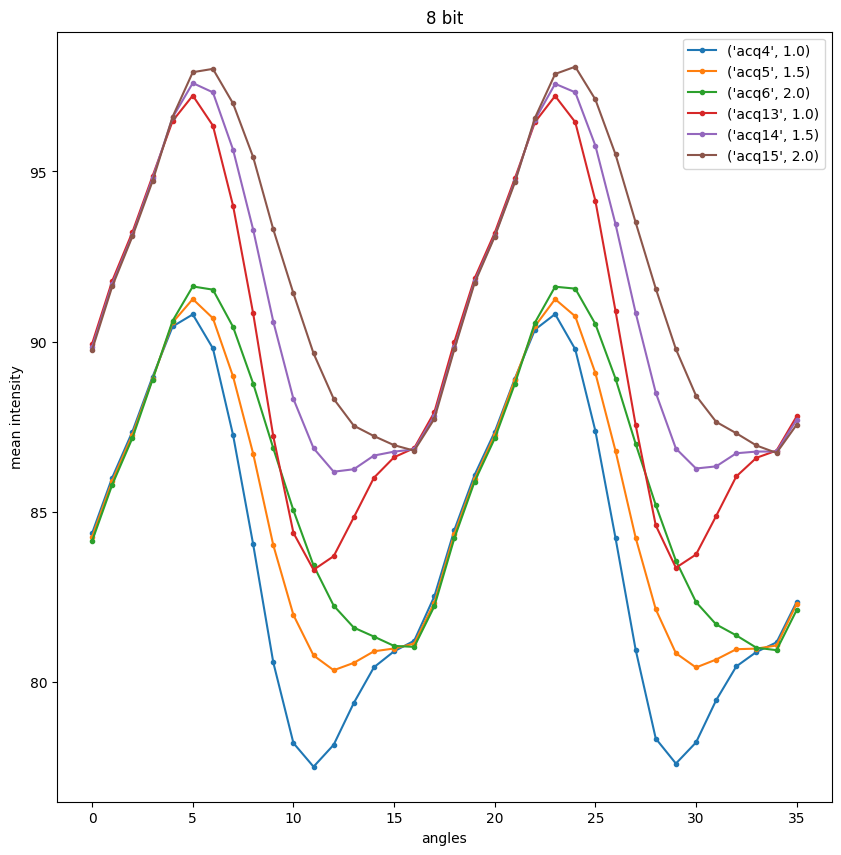

In [5]:

plt.figure(figsize=(10,10))
for mean_intensity in cal_mean_intensity(RGB_acq_list,"gain",1):
    gamma = get_acq_info(mean_intensity[1],RGB_acq_list)[3]
    plt.plot(inv_gamma(mean_intensity[0],gamma),'.-',label=(mean_intensity[1],gamma))
plt.legend()
plt.xlabel("angles")
plt.ylabel("mean intensity")
plt.title("RGB images mean intensity vs angles for gain=1 by basler camera acA5472-17uc")


In [6]:
red,green,blue=cal_mean_intensity_by_channels(RGB_acq_list,"exposure",9600)

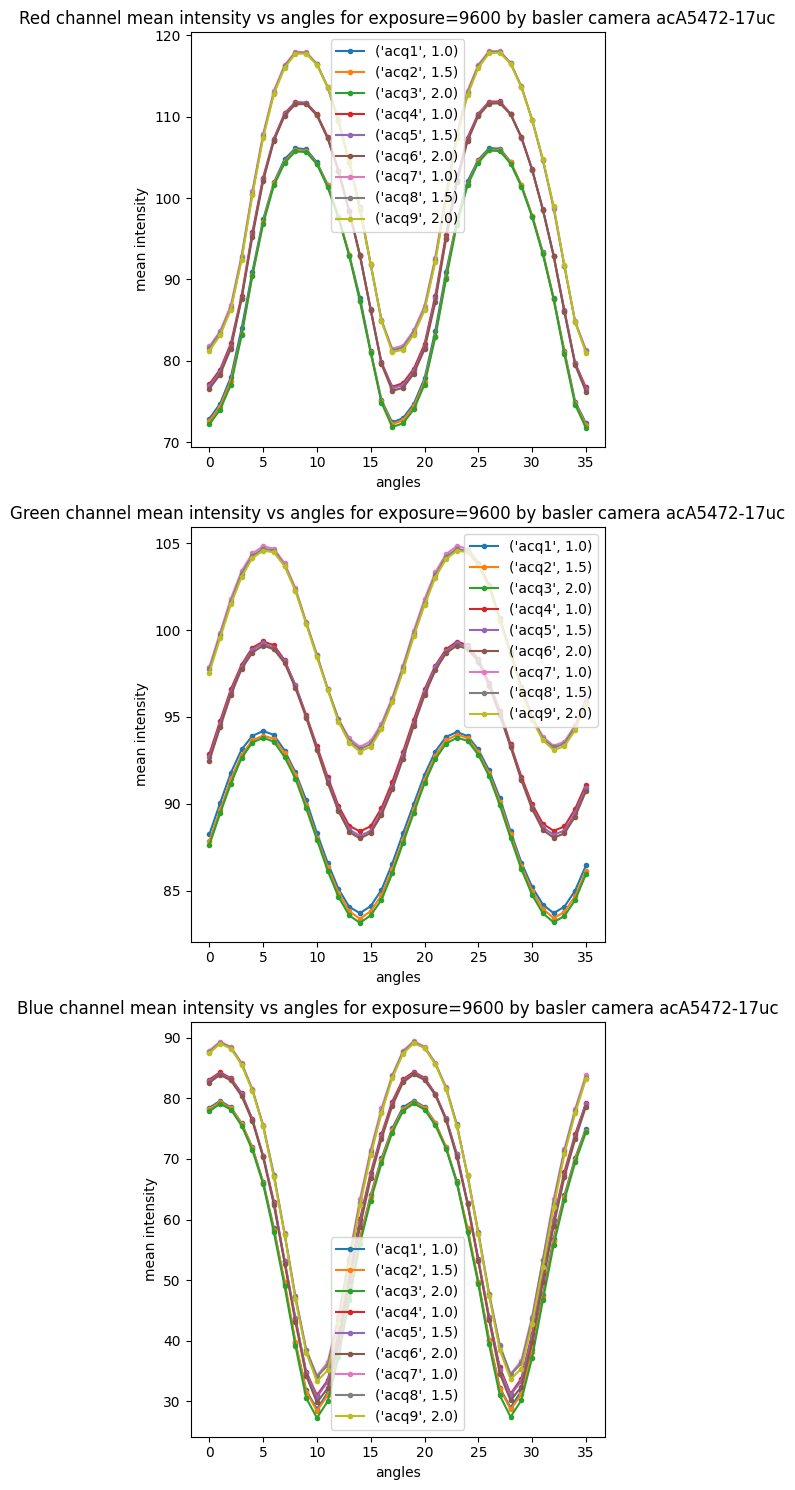

In [12]:

plt.subplots(3,1,figsize=(5,15))

plt.subplot(3,1,1)
for mean_intensity in reg:
    gamma = get_acq_info(mean_intensity[1],RGB_acq_list)[3]
    plt.plot(inv_gamma(mean_intensity[0],gamma),'.-',label=(mean_intensity[1],gamma))
plt.legend()
plt.xlabel("angles")
plt.ylabel("mean intensity")
plt.title("Red channel mean intensity vs angles for exposure=9600 by basler camera acA5472-17uc")

plt.subplot(3,1,2)
for mean_intensity in green:
    gamma = get_acq_info(mean_intensity[1],RGB_acq_list)[3]
    plt.plot(inv_gamma(mean_intensity[0],gamma),'.-',label=(mean_intensity[1],gamma))
plt.legend()
plt.xlabel("angles")
plt.ylabel("mean intensity")

plt.title("Green channel mean intensity vs angles for exposure=9600 by basler camera acA5472-17uc")

plt.subplot(3,1,3)
for mean_intensity in blue:
    gamma = get_acq_info(mean_intensity[1],RGB_acq_list)[3]
    plt.plot(inv_gamma(mean_intensity[0],gamma),'.-',label=(mean_intensity[1],gamma))
plt.legend()
plt.xlabel("angles")
plt.ylabel("mean intensity")
plt.title("Blue channel mean intensity vs angles for exposure=9600 by basler camera acA5472-17uc")

plt.tight_layout()


acq1 1.0 0.0
acq2 1.5 0.0
acq3 2.0 0.0
acq4 1.0 1.0
acq5 1.5 1.0
acq6 2.0 1.0
acq7 1.0 2.0
acq8 1.5 2.0
acq9 2.0 2.0


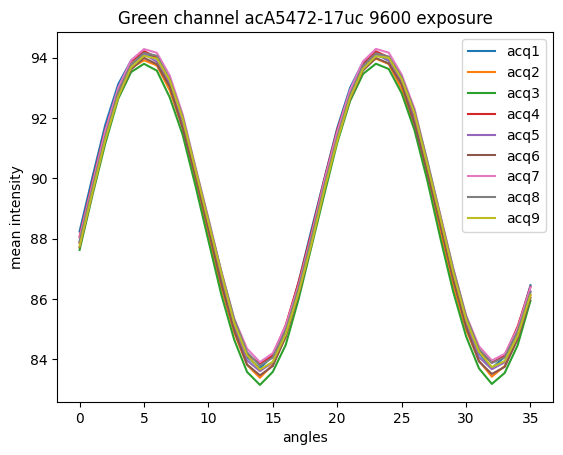

In [13]:
for mi, lable in green:
    gamma = get_acq_info(lable,RGB_acq_list)[3]
    gain = get_acq_info(lable,RGB_acq_list)[2]
    print(lable,gamma,gain)

    plt.plot(np.divide(inv_gamma(mi,gamma),np.exp(gain/18.888)), label=lable)
    plt.legend()
    plt.xlabel("angles")
    plt.ylabel("mean intensity")
    plt.title("Green channel acA5472-17uc 9600 exposure")
    # plt.ylim(93.2,94.5)
    # plt.xlim(3,6)

In [26]:
def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def calculate_psnr(image1, image2):
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0  
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# calculate mse and psnr for the gamma corrected images by the index of the images
def calculate_mse_psnr_by_index(img1,img2):
    mse = calculate_mse(img1,img2)
    psnr = calculate_psnr(img1,img2)
    return mse,psnr

In [19]:
def inv_gain(x,gain):
    temp=np.zeros(len(x))
    for i in range(len(x)):
        temp[i] =np.divide(x[i], np.exp(gain/18.888))
    return temp

In [21]:
gamma_gain_corrected_mean_intensities_green_channel = []
for mi, lable in green:
    gamma = get_acq_info(lable,RGB_acq_list)[3]
    gain = get_acq_info(lable,RGB_acq_list)[2]
    gamma_gain_corrected_mean_intensities_green_channel.append((inv_gain(inv_gamma(mi,gamma),gain),lable))

In [22]:
gamma_gain_corrected_mean_intensities_green_channel

[(array([88.23756559, 90.04288549, 91.781169  , 93.1233229 , 93.90771214,
         94.18944381, 93.96259671, 93.06012001, 91.81346193, 90.20693171,
         88.30985741, 86.6020103 , 85.10212653, 84.06483075, 83.70299029,
         84.11224578, 85.04206628, 86.55310418, 88.29628237, 89.99429422,
         91.66874834, 93.00728715, 93.85024293, 94.12483008, 93.90059471,
         93.12339965, 91.91868497, 90.33635705, 88.40816921, 86.61971462,
         85.20963902, 84.19904236, 83.70369038, 84.07480076, 85.00647285,
         86.45261032]),
  'acq1'),
 (array([87.85110562, 89.65142335, 91.41860704, 92.80341344, 93.65963355,
         93.91734428, 93.74385675, 92.91748871, 91.66556255, 89.94707693,
         88.0534057 , 86.35795925, 84.87628546, 83.80781491, 83.38189365,
         83.8226485 , 84.73311886, 86.23278737, 87.92681067, 89.67713043,
         91.39039189, 92.75454131, 93.65032921, 93.97033913, 93.79168653,
         92.95661036, 91.74437358, 90.12207609, 88.23355961, 86.42201933,
   

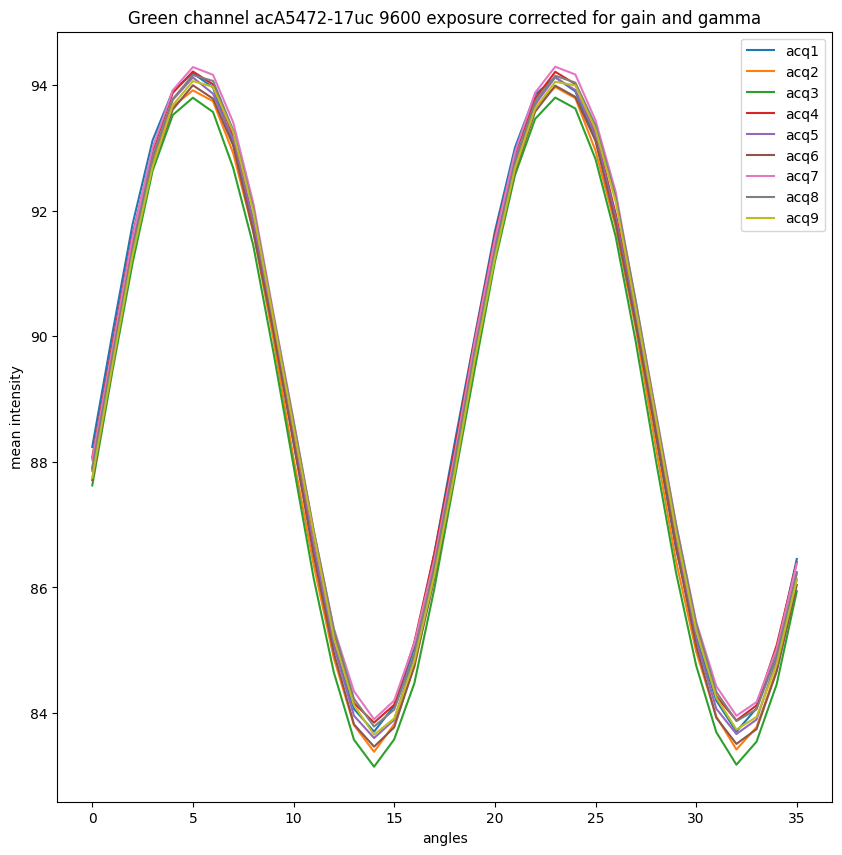

In [23]:
# plot the corrected mean intensities
plt.figure(figsize=(10,10))

for mi, lable in gamma_gain_corrected_mean_intensities_green_channel:
    plt.plot(mi, label=lable)
    plt.legend()
    plt.xlabel("angles")
    plt.ylabel("mean intensity")
    plt.title("Green channel acA5472-17uc 9600 exposure corrected for gain and gamma")
    # plt.ylim(93.2,94.5)
    # plt.xlim(3,6)

    

In [25]:
gamma_gain_corrected_mean_intensities_green_channel[0][0]

array([88.23756559, 90.04288549, 91.781169  , 93.1233229 , 93.90771214,
       94.18944381, 93.96259671, 93.06012001, 91.81346193, 90.20693171,
       88.30985741, 86.6020103 , 85.10212653, 84.06483075, 83.70299029,
       84.11224578, 85.04206628, 86.55310418, 88.29628237, 89.99429422,
       91.66874834, 93.00728715, 93.85024293, 94.12483008, 93.90059471,
       93.12339965, 91.91868497, 90.33635705, 88.40816921, 86.61971462,
       85.20963902, 84.19904236, 83.70369038, 84.07480076, 85.00647285,
       86.45261032])

In [27]:
# calculate the mse and psnr between the images taking green[0] as the reference acquisition 
ref_acq = gamma_gain_corrected_mean_intensities_green_channel[0][0]
mse_by_acq=[]
psnr_by_acq=[]

for i in range(len(gamma_gain_corrected_mean_intensities_green_channel)):
    mse=[]
    psnr=[]
    for j in range(len(ref_acq)):
        mse_temp,psnr_temp = calculate_mse_psnr_by_index(ref_acq[j],gamma_gain_corrected_mean_intensities_green_channel[1][0][j])
        label = gamma_gain_corrected_mean_intensities_green_channel[i][1]
        mse.append(mse_temp)
        psnr.append((psnr_temp))
    mse_by_acq.append((mse, label))
    psnr_by_acq.append((psnr, label))
    

Text(0.5, 1.0, 'MSE between the reference image and the other images')

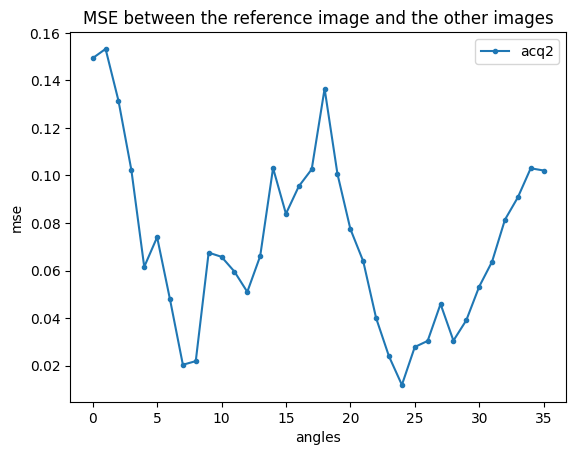

In [28]:
plt.plot(mse_by_acq[1][0],'.-',label=f"{mse_by_acq[1][1]}")
plt.legend()
plt.xlabel("angles")
plt.ylabel("mse")
plt.title("MSE between the reference image and the other images")

Text(0.5, 1.0, 'MSE between the reference image and the other images')

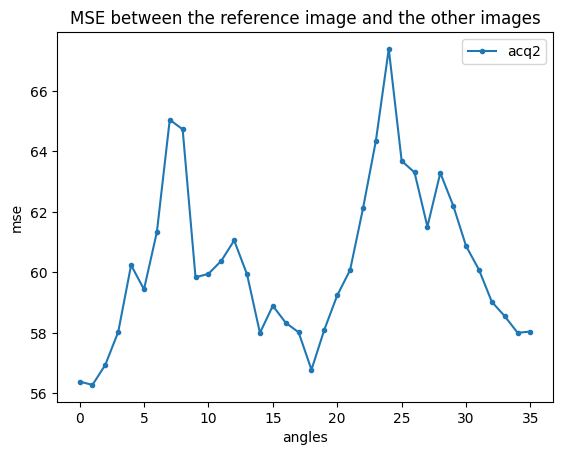

In [29]:
plt.plot(psnr_by_acq[1][0],'.-',label=f"{mse_by_acq[1][1]}")
plt.legend()
plt.xlabel("angles")
plt.ylabel("mse")
plt.title("MSE between the reference image and the other images")